In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [29]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

In [21]:
learning_rate = 1e-3
optm = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [22]:
def ODE(x, net):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    x_0 = tf.zeros((1, 1))
    one = tf.ones((1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x)

        u = net(x)
        u_x = tape.gradient(u, x)

    ode_loss = u_x - tf.math.cos(2*np.pi*x)
    IC_loss = net(x_0) - one

    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss


2.9476755
0.52179396
0.32328793
0.28252918
0.0012171161
0.0004125647


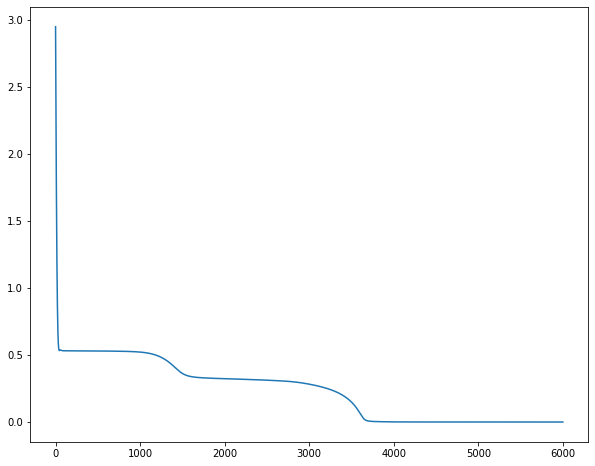

In [23]:
train_x = (np.random.rand(30)*2).reshape(-1, 1)
train_loss_recode = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ODE(train_x, NN)
        train_loss_recode.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10, 8))
plt.plot(train_loss_recode)
plt.show()

4/4 [==============================] - 0s 2ms/step


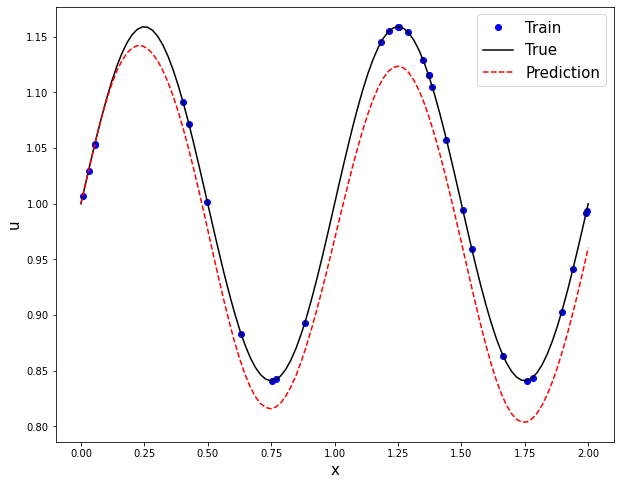

In [24]:
from cProfile import label

test_x = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_x) / (2*np.pi) + 1
true_u = np.sin(2*np.pi*test_x) / (2*np.pi) + 1
pred_u = NN.predict(test_x).ravel()

plt.figure(figsize = (10,8))
plt.plot(train_x, train_u, 'ob', label = 'Train')
plt.plot(test_x, true_u, '-k', label = 'True')
plt.plot(test_x, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

In [26]:
def psy_analytic(x, lamb = 1, case = 1):
    '''
        psy_analytic = np.exp(lamb*x)
    '''
    if case == 1:
        return tf.exp(lamb*x)
    elif case == 2:
        return tf.sin(x)
    elif case == 3:
        return -1 / (1 + x)

def A(x, case = 1):
    if case == 1:
        return -1

def B(x, case = 1):
    if case == 1:
        return 0

def f(x, psy, case = 1):
    if case == 1:
        '''
            d(psy)/dx = f(x, psy)
            y' = B(x) - A(x) * y
        '''
        return B(x) - A(x)*psy
    
    elif case == 2:
        '''
            Prothero Robinson
            y' 
        '''
        return -(psy - tf.sin(x)) + tf.cos(x)

    elif case == 3:
        return psy**2

def y(x, w, n = 4, case = 1): 
    '''
        y(x) = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    if case == 1:
        bias = 1.
    elif case == 2:
        bias = 0.
    elif case == 3:
        bias = -1.

    y = bias
    for i in range(1, n+1):
        y += w[i-1]*x**i
    
    return y

def yprime(x, w, n=4, bias = 0.):
    '''
        yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3) + ... + n*wn*(x**(n-1))
    '''
    yprime = bias
    for i in range(n):
        yprime += (i+1)*w[i]*x**i
    
    return yprime

In [27]:
def loss_function_yhat(w, x, n, case = 1):
    err_sqr = tf.abs(tf.square(yprime(x, w, n, bias = 0) - f(x, y(x, w, n, case = case), case)))
    loss_sum = tf.sqrt(tf.reduce_mean(err_sqr))
    return loss_sum

In [31]:
'''
    yhat_w_loss 출력
    w 값, low_loss_sum(가장 낮은 지점 loss 합)

    yhat 값 생성 방법
    yhat_w, yhat_loss = yhat_w_loss(x, 차수)
    yhat = y(x, yhat_w, 차수, bias)
'''
def yhat_w_loss(x, n = 4, case = 1, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf):
    print('Start yhat')
    # # exel 데이터 저장
    # wb = Workbook()

    # ws1 = wb.active
    # ws1.title = 'n, learning_rate, low_loss_Epoch, total_Epoch'
    # ws2 = wb.create_sheet(title='yhat w')
    # ws3 = wb.create_sheet(title='yhat loss_sum')

    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32, seed=777), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]
    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # 옵티마이져 종류 Adam, SDG, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl 가능
    learning_rate = 1e-3
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        loss_sum = 0.0
        with tf.GradientTape() as tape:
            loss_sum = loss_function_yhat(w, x, n, case)

        # ws2.append(list(w.numpy()))
        # ws3.append([float(loss_sum)])
        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w
            low_loss_Epoch = Epoch
        '''
            target_loss : 초기값 inf, 값을 정해 줄 수 있음.
            low_loss : 반복중 가장 낮은 loss 값
            early_stop : 초기값 inf, low_loss를 구하고 얼마나 반복 하고 멈출 것인지.
            조건
            1. target_loss 보다 loss_sum이 작아졌는지
            2. low_loss 보다 loss_sum이 작아졌는지

            조건 1, 2 만족 시 low_loss가 loss_sum으로 변경

            3. low_loss가 갱신된 Epoch 부터 지정한 early_stop 값 만큼 반복 후 중단.
        '''
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break

        # 학습 중간에 출력
        if Epoch % 1000 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, w.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break
        Epoch += 1
        
        # Gradient 값 저장
        gradients = tape.gradient(loss_sum, w)
        # Gradient 값 w에 적용
        optimizer.apply_gradients(zip([gradients], [w]))

    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))
    
    # ws1.append([n, learning_rate, low_loss_Epoch, Epoch])
    # wb.save('case{}_{}차_yhat.xlsx'.format(case, n))

    return early_stop_w, low_loss

In [35]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
case = 1
case1_yhat_w_1, case1_low_loss_1 = yhat_w_loss(x, n, early_stop=1, case = case)
case1_yhat_1 = y(x, case1_yhat_w_1, n, case=case)
case1_yhatprime_1 = yprime(x, case1_yhat_w_1, n, bias = 0)

Start yhat
Epoch : 0, Loss_sum : 0.5243, w : [1.2014729]
early stop
low_loss_Epoch : 687, low_Loss_sum : 0.4963, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.4901452], dtype=float32)>


In [39]:
def EC_ODE(x, net, _y, _yprime):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    x_0 = tf.zeros((1, 1))
    one = tf.ones((1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x)

        u = net(x)
        u_x = tape.gradient(u, x)

    ode_loss = u_x - f(x, u)
    IC_loss = net(x_0) - one
    y_loss = _yprime - _y

    square_loss = tf.square(ode_loss) + tf.square(IC_loss) + tf.square(y_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss


1.2681777
0.2463062
0.24643497
0.24628766
0.24633422
0.24627852


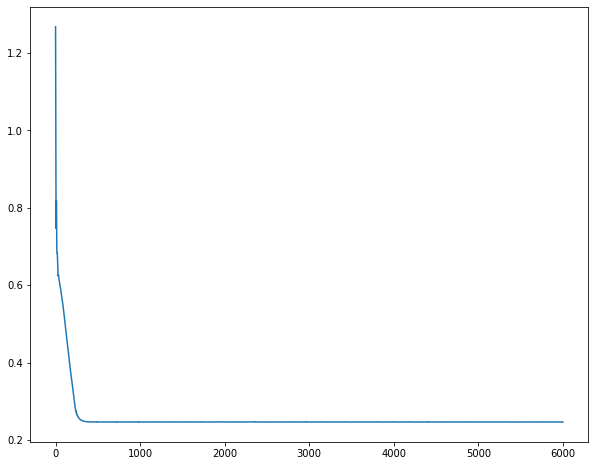

In [40]:
train_x = (np.random.rand(30)*2).reshape(-1, 1)
train_loss_recode = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = EC_ODE(train_x, NN, case1_yhat_1, case1_yhatprime_1)
        train_loss_recode.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10, 8))
plt.plot(train_loss_recode)
plt.show()

4/4 [==============================] - 0s 2ms/step


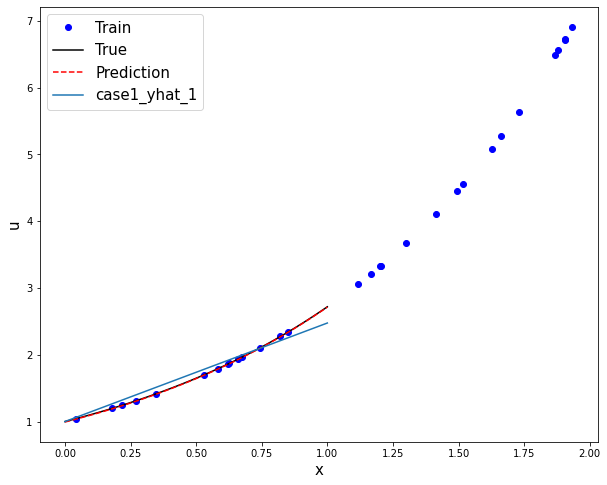

In [54]:
from cProfile import label

test_x = np.linspace(0, 2, 100)

train_u = tf.exp(train_x)
true_u = tf.exp(test_x)
pred_u = NN.predict(test_x).ravel()

plt.figure(figsize = (10,8))
plt.plot(train_x, train_u, 'ob', label = 'Train')
plt.plot(test_x, true_u, '-k', label = 'True')
plt.plot(test_x, pred_u, '--r', label = 'Prediction')
plt.plot(test_x, case1_yhat_1, label = 'case1_yhat_1')
plt.legend(fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

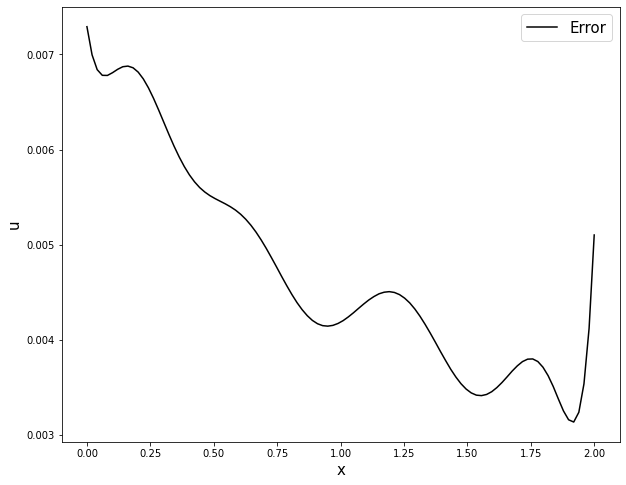

In [47]:
plt.figure(figsize = (10,8))
# plt.plot(train_x, train_u, 'ob', label = 'Train')
plt.plot(test_x, tf.abs(pred_u - true_u), '-k', label = 'Error')
# plt.plot(test_x, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

In [48]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 3
case = 1
case1_yhat_w_3, case1_low_loss_3 = yhat_w_loss(x, n, early_stop=1, case = case)
case1_yhat_3 = y(x, case1_yhat_w_3, n, case=case)
case1_yhatprime_3 = yprime(x, case1_yhat_w_3, n, bias = 0)

Start yhat
Epoch : 0, Loss_sum : 1.2574, w : [ 0.87544113 -0.7350446  -0.12203535]
Epoch : 1000, Loss_sum : 0.0653, w : [ 1.1724834  -0.01216255  0.56166327]
Epoch : 2000, Loss_sum : 0.0276, w : [1.0785799 0.244455  0.3964366]
early stop
low_loss_Epoch : 2708, low_Loss_sum : 0.0053, low_loss_w : <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1.0124443 , 0.4268346 , 0.27873647], dtype=float32)>


0.24641764
0.24627863
0.24627665
0.24627458
0.24627331
0.2462727


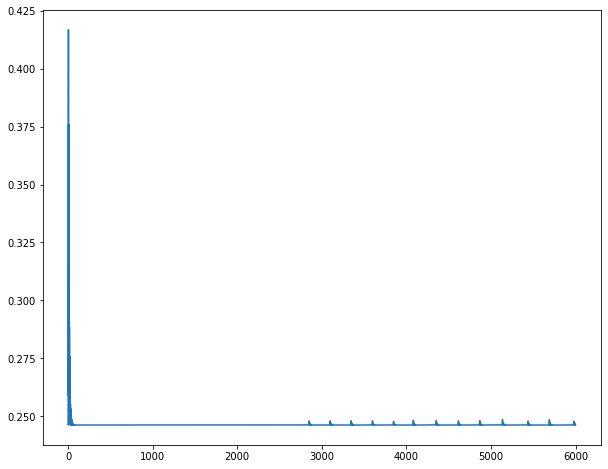

In [55]:
train_x = (np.random.rand(30)).reshape(-1, 1)
train_loss_recode = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = EC_ODE(train_x, NN, case1_yhat_1, case1_yhatprime_1)
        train_loss_recode.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10, 8))
plt.plot(train_loss_recode)
plt.show()

4/4 [==============================] - 0s 2ms/step


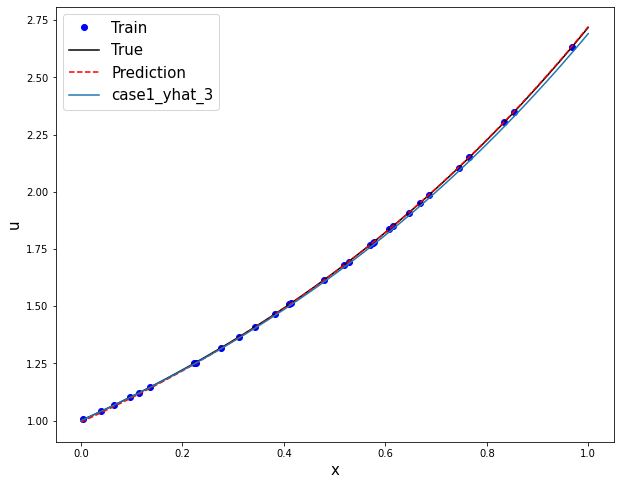

In [56]:
from cProfile import label

test_x = np.linspace(0, 1, 100)

train_u = tf.exp(train_x)
true_u = tf.exp(test_x)
pred_u = NN.predict(test_x).ravel()

plt.figure(figsize = (10,8))
plt.plot(train_x, train_u, 'ob', label = 'Train')
plt.plot(test_x, true_u, '-k', label = 'True')
plt.plot(test_x, pred_u, '--r', label = 'Prediction')
plt.plot(test_x, case1_yhat_3, label = 'case1_yhat_3')
plt.legend(fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

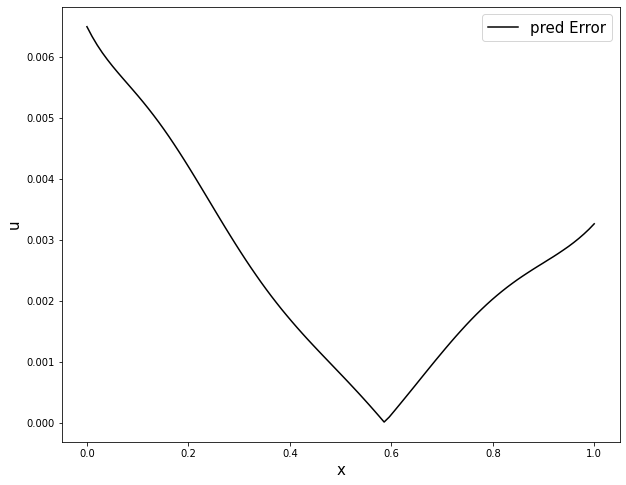

In [59]:
plt.figure(figsize = (10,8))
plt.plot(test_x, tf.abs(pred_u - true_u), '-k', label = 'pred Error')
# plt.plot(test_x, tf.abs(case1_yhat_3 - true_u), '--r', label = 'y Error')
plt.legend(fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

In [428]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

def A(x, case = 1):
    if case == 1:
        return -1

def B(x, case = 1):
    if case == 1:
        return 0

def f(x, psy, case = 1):
    if case == 1:
        '''
            d(psy)/dx = f(x, psy)
            y' = B(x) - A(x) * y
        '''
        return B(x) - A(x)*psy
    
    elif case == 2:
        '''
            Prothero Robinson
            y' 
        '''
        return -(psy - tf.sin(x)) + tf.cos(x)

    elif case == 3:
        return psy**2

def y(x, w, case = 1): 
    '''
        y(x) = bias + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    if case == 1:
        bias = 1.
    elif case == 2:
        bias = 0.
    elif case == 3:
        bias = -1.

    y = bias
    w_v = w.variables[0]
    n = w_v.shape[0]
    for i in range(1, n+1):
        y += w_v[i-1]*x**i
    
    return y

def y_loss(x, w, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    
    # x_0 = tf.zeros((1, 1))
    # one = tf.ones((1, 1))
    
    with tf.GradientTape() as tape:
        tape.watch(x)

        _y = y(x, w, case = 1)
        d_y = tape.gradient(_y, x)
    
    _loss = d_y - f(x, _y, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def y_EC_loss(x, w, NN, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    x_0 = tf.zeros((1, 1))
    one = tf.ones((1, 1))
    w_v = w.variables[0]
    n = w_v.shape[0]

    with tf.GradientTape() as tape:
        tape.watch(x)

        y_EC = tf.add(y(x, w, case), NN(x)*x)
        d_y_EC = tape.gradient(y_EC, x)

    _loss = d_y_EC - f(x, y_EC, case)
    init_loss = NN(x_0) - one
    square_loss = tf.square(_loss) + tf.square(init_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def train(n, case):
    NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    train_x = (np.random.rand(30)).reshape(-1, 1)
    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(n, ), dtype=tf.float32))

    print('start y')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))

    print('start y + EC')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_EC_loss(train_x, w, NN, case)

            grad_NN = tape.gradient(train_loss, NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))
    
    return w, NN

start y
iter : 0, loss : 0.27002519369125366
iter : 1000, loss : 0.26899877190589905
iter : 2000, loss : 0.26899877190589905
start y + EC
iter : 0, loss : 1.1927298307418823
iter : 1000, loss : 3.626419129432179e-05
iter : 2000, loss : 8.584645911469124e-06


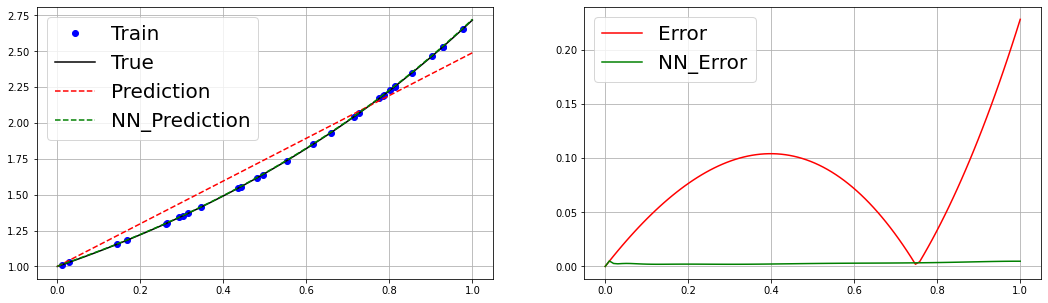

In [429]:
n = 1
case = 1
w, NN = train(n, case)
test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

pred_y = y(test_x, w, case)
NN_pred_y = tf.add(y(test_x, w, case), NN(test_x)*test_x)

test_x = np.linspace(0, 1, 100)
train_y = tf.exp(train_x)
true_y = tf.exp(test_x)

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(train_x, train_y, 'ob', label = 'Train')
ax.plot(test_x, true_y, '-k', label = 'True')
ax.plot(test_x, pred_y, '--r', label = 'Prediction')
ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()

start y
iter : 0, loss : 0.40315186977386475
iter : 1000, loss : 0.020704617723822594
iter : 2000, loss : 0.003923905547708273
start y + EC
iter : 0, loss : 1.004395842552185
iter : 1000, loss : 7.544539403170347e-05
iter : 2000, loss : 1.9072222130489536e-05


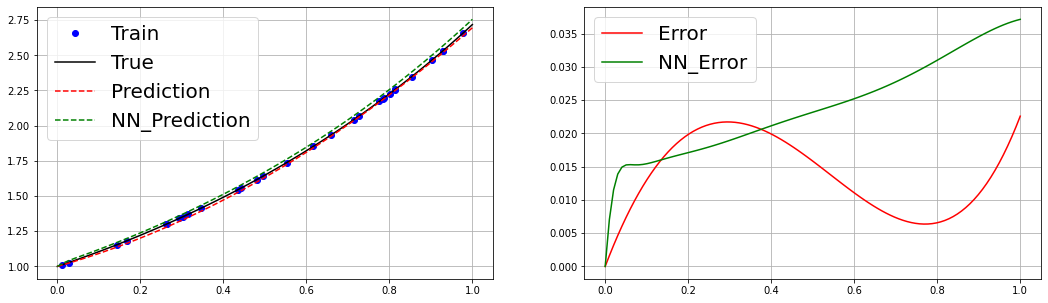

In [430]:
n = 2
case = 1
w, NN = train(n, case)
test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

pred_y = y(test_x, w, case)
NN_pred_y = tf.add(y(test_x, w, case), NN(test_x)*test_x)

test_x = np.linspace(0, 1, 100)
train_y = tf.exp(train_x)
true_y = tf.exp(test_x)

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(train_x, train_y, 'ob', label = 'Train')
ax.plot(test_x, true_y, '-k', label = 'True')
ax.plot(test_x, pred_y, '--r', label = 'Prediction')
ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()

start y
iter : 0, loss : 7.8323211669921875
iter : 1000, loss : 3.0206048488616943
iter : 2000, loss : 1.4515095949172974
start y + EC
iter : 0, loss : 1.6857846975326538
iter : 1000, loss : 0.008219663053750992
iter : 2000, loss : 0.0036100626457482576


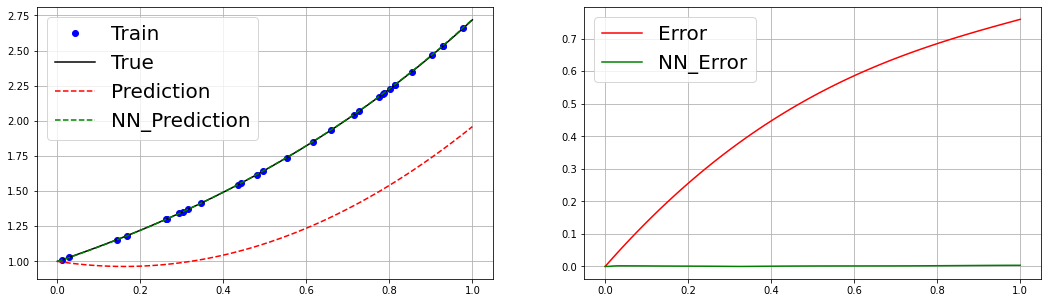

In [427]:
n = 3
case = 1
w, NN = train(n, case)
test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

pred_y = y(test_x, w, case)
NN_pred_y = tf.add(y(test_x, w, case), NN(test_x)*test_x)

test_x = np.linspace(0, 1, 100)
train_y = tf.exp(train_x)
true_y = tf.exp(test_x)

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(train_x, train_y, 'ob', label = 'Train')
ax.plot(test_x, true_y, '-k', label = 'True')
ax.plot(test_x, pred_y, '--r', label = 'Prediction')
ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()

start y
iter : 0, loss : 15.376886367797852
iter : 1000, loss : 6.53537130355835
iter : 2000, loss : 2.1403610706329346
start y + EC
iter : 0, loss : 3.5881025791168213
iter : 1000, loss : 0.0024838882964104414
iter : 2000, loss : 0.00035681918961927295


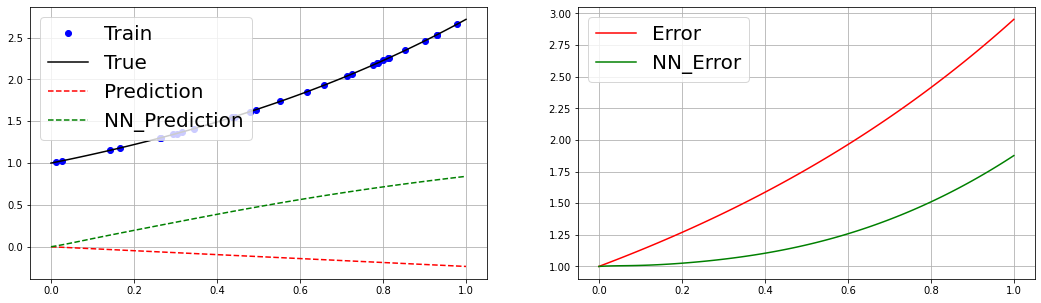

In [431]:
n = 1
case = 2
w, NN = train(n, case)
test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

pred_y = y(test_x, w, case)
NN_pred_y = tf.add(y(test_x, w, case), NN(test_x)*test_x)

test_x = np.linspace(0, 1, 100)
train_y = tf.exp(train_x)
true_y = tf.exp(test_x)

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(train_x, train_y, 'ob', label = 'Train')
ax.plot(test_x, true_y, '-k', label = 'True')
ax.plot(test_x, pred_y, '--r', label = 'Prediction')
ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()

start y
iter : 0, loss : 4.525797367095947
iter : 1000, loss : 0.04320111498236656
iter : 2000, loss : 0.00206178892403841
start y + EC
iter : 0, loss : 2.365046977996826
iter : 1000, loss : 0.0010680790292099118
iter : 2000, loss : 0.0005205848137848079


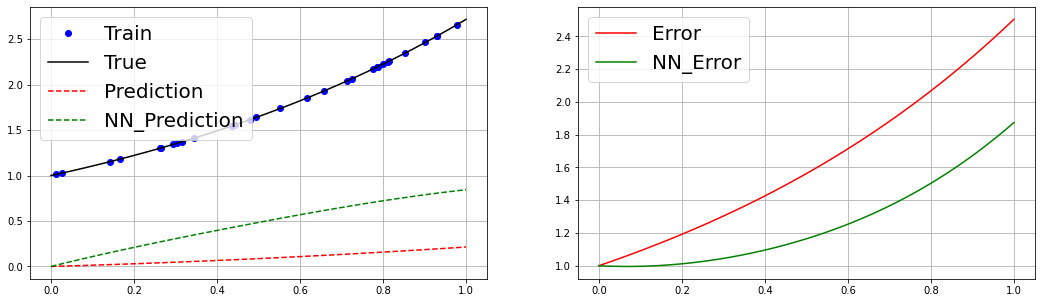

In [432]:
n = 2
case = 2
w, NN = train(n, case)
test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

pred_y = y(test_x, w, case)
NN_pred_y = tf.add(y(test_x, w, case), NN(test_x)*test_x)

test_x = np.linspace(0, 1, 100)
train_y = tf.exp(train_x)
true_y = tf.exp(test_x)

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(train_x, train_y, 'ob', label = 'Train')
ax.plot(test_x, true_y, '-k', label = 'True')
ax.plot(test_x, pred_y, '--r', label = 'Prediction')
ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()

start y
iter : 0, loss : 4.316141128540039
iter : 1000, loss : 1.2468408346176147
iter : 2000, loss : 0.39116719365119934
start y + EC
iter : 0, loss : 1.6798187494277954
iter : 1000, loss : 0.0048896209336817265
iter : 2000, loss : 0.0021790999453514814


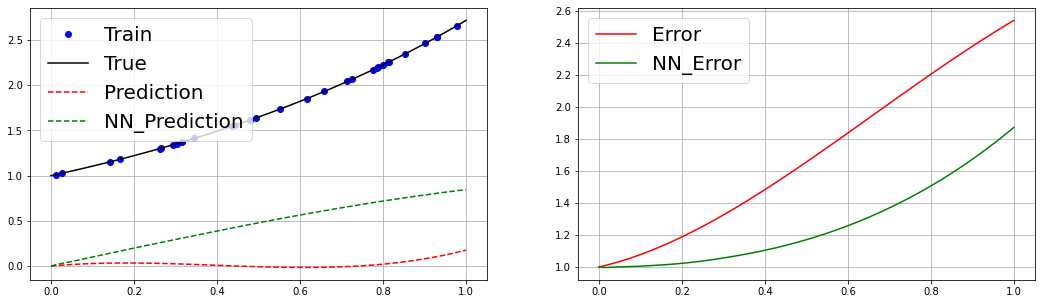

In [433]:
n = 3
case = 2
w, NN = train(n, case)
test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

pred_y = y(test_x, w, case)
NN_pred_y = tf.add(y(test_x, w, case), NN(test_x)*test_x)

test_x = np.linspace(0, 1, 100)
train_y = tf.exp(train_x)
true_y = tf.exp(test_x)

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(train_x, train_y, 'ob', label = 'Train')
ax.plot(test_x, true_y, '-k', label = 'True')
ax.plot(test_x, pred_y, '--r', label = 'Prediction')
ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()

start y
iter : 0, loss : 1.0007067918777466
iter : 1000, loss : 0.9973490238189697
iter : 2000, loss : 0.9973490238189697
start y + EC
iter : 0, loss : 2.0460829734802246
iter : 1000, loss : 9.873507224256173e-05
iter : 2000, loss : 7.63476054999046e-05


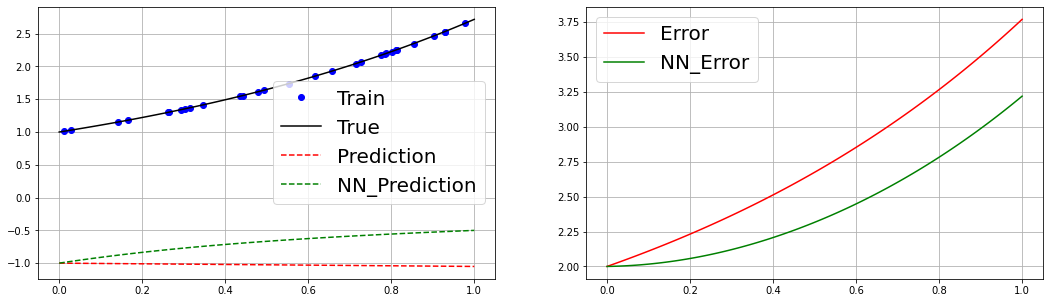

In [434]:
n = 1
case = 3
w, NN = train(n, case)
test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

pred_y = y(test_x, w, case)
NN_pred_y = tf.add(y(test_x, w, case), NN(test_x)*test_x)

test_x = np.linspace(0, 1, 100)
train_y = tf.exp(train_x)
true_y = tf.exp(test_x)

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(train_x, train_y, 'ob', label = 'Train')
ax.plot(test_x, true_y, '-k', label = 'True')
ax.plot(test_x, pred_y, '--r', label = 'Prediction')
ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()

start y
iter : 0, loss : 8.370840072631836
iter : 1000, loss : 2.25077486038208
iter : 2000, loss : 1.1851050853729248
start y + EC
iter : 0, loss : 1.3069618940353394
iter : 1000, loss : 7.891825953265652e-05
iter : 2000, loss : 8.96984329301631e-06


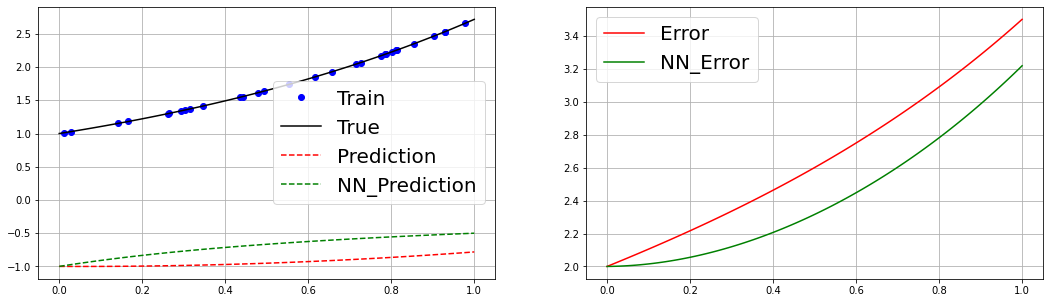

In [435]:
n = 2
case = 3
w, NN = train(n, case)
test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

pred_y = y(test_x, w, case)
NN_pred_y = tf.add(y(test_x, w, case), NN(test_x)*test_x)

test_x = np.linspace(0, 1, 100)
train_y = tf.exp(train_x)
true_y = tf.exp(test_x)

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(train_x, train_y, 'ob', label = 'Train')
ax.plot(test_x, true_y, '-k', label = 'True')
ax.plot(test_x, pred_y, '--r', label = 'Prediction')
ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()

start y
iter : 0, loss : 1.3767945766448975
iter : 1000, loss : 0.562982976436615
iter : 2000, loss : 0.4850134253501892
start y + EC
iter : 0, loss : 2.5245776176452637
iter : 1000, loss : 0.0007864836370572448
iter : 2000, loss : 0.0006570905679836869


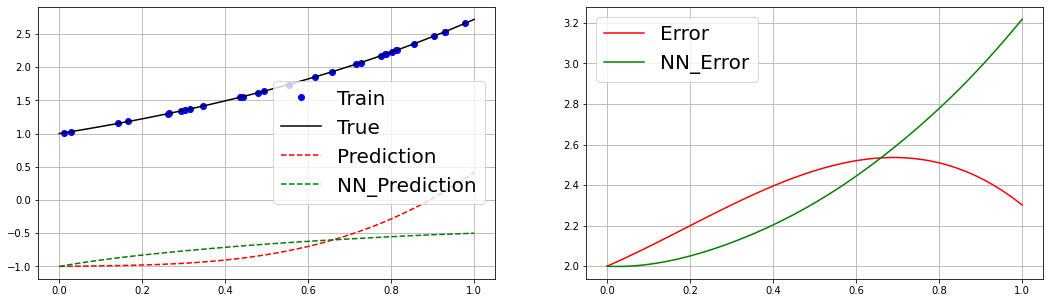

In [436]:
n = 3
case = 3
w, NN = train(n, case)
test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

pred_y = y(test_x, w, case)
NN_pred_y = tf.add(y(test_x, w, case), NN(test_x)*test_x)

test_x = np.linspace(0, 1, 100)
train_y = tf.exp(train_x)
true_y = tf.exp(test_x)

# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(train_x, train_y, 'ob', label = 'Train')
ax.plot(test_x, true_y, '-k', label = 'True')
ax.plot(test_x, pred_y, '--r', label = 'Prediction')
ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()